In [1]:
## NEED TO RUN THIS TO GET CHOLMOD TO WORK
import ctypes

CUDA_LIB = "/share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib"
OPENBLAS = "/share/software/user/open/openblas/0.3.20/lib"
SUITESPARSE = "/share/software/user/open/suitesparse/7.4.0/lib64"

libs_to_load = [
    f"{OPENBLAS}/libopenblas.so.0",
    f"{CUDA_LIB}/libnvrtc.so.12",
    f"{CUDA_LIB}/libcublas.so.12",
    f"{CUDA_LIB}/libcublasLt.so.12",
    f"{CUDA_LIB}/libnvrtc-builtins.so.12.2",
    f"{SUITESPARSE}/libcholmod.so.5",
]

# Load each library with global visibility
for lib in libs_to_load:
    print(f"Loading {lib} ...")
    ctypes.CDLL(lib, mode=ctypes.RTLD_GLOBAL)

# Import sksparse safely
import sksparse.cholmod as cholmod
print("✓ sksparse imported successfully")


Loading /share/software/user/open/openblas/0.3.20/lib/libopenblas.so.0 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libnvrtc.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libcublas.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libcublasLt.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libnvrtc-builtins.so.12.2 ...
Loading /share/software/user/open/suitesparse/7.4.0/lib64/libcholmod.so.5 ...
✓ sksparse imported successfully


In [2]:
import cvxpy as cp
import numpy as np
import time
import clarabel
import torch
import matplotlib.pyplot as plt
from zap.admm import ADMMSolver, WeightedADMMSolver
from zap.conic.cone_bridge import ConeBridge
import scipy.sparse as sp
from experiments.conic_solve.benchmarks.max_flow_benchmark import MaxFlowBenchmarkSet

from zap.conic.cone_utils import get_standard_conic_problem



In [3]:
## Create a large problem that is valid using max flow benchmark set 
n = 10000
base_seed = 42
max_flow_benchmark = MaxFlowBenchmarkSet(num_problems=1, n=n, base_seed=base_seed)

for prob in max_flow_benchmark:
    problem = prob
num_variables = sum(np.prod(var.shape) for var in problem.variables())
num_constraints = sum(constraint.size for constraint in problem.constraints)
nnz = num_variables # This is the actual number of edges
total_possible_edges = float(n*(n - 1))
density = nnz/total_possible_edges
sparsity = 1 - density
print(f'Generated a valid network with {n} nodes using starting seed {base_seed}')
print(f"Actual Number of Edges: {nnz}")
print(f"Total Possible Edges: {total_possible_edges}")
print(f"Graph sparsity: {sparsity}")
print(f"Graph density: {density}")
print(f"Number of Variables: {num_variables}")
print(f"Number of Constraints: {num_constraints}")

Generated a valid network with 10000 nodes using starting seed 42
Actual Number of Edges: 183993
Total Possible Edges: 99990000.0
Graph sparsity: 0.9981598859885988
Graph density: 0.0018401140114011401
Number of Variables: 183993
Number of Constraints: 193993


In [4]:
# Get conic problem form so we can (i) solve standard conic form and (ii) solve using ZAP
cone_params, data, cones = get_standard_conic_problem(problem, solver=cp.CLARABEL)

In [10]:
# Solve the conic form using ZAP
machine = 'cuda'
dtype = torch.float32
cone_bridge = ConeBridge(cone_params)
cone_admm_devices = [d.torchify(machine=machine, dtype=dtype) for d in cone_bridge.devices]
cone_admm = WeightedADMMSolver(
    machine=machine,
    dtype=dtype,
    atol=1e-6,
    rtol=1e-6,
    alpha=1.6,
    tau=2,
    adaptive_rho=True,
    # adaptation_frequency=60,
    num_iterations=10000,
)
start_time = time.time()
cone_solution_admm, cone_history_admm = cone_admm.solve(
    net=cone_bridge.net, devices=cone_admm_devices, time_horizon=cone_bridge.time_horizon
)
end_time = time.time()
solve_time = end_time - start_time
obj_val = cone_solution_admm.objective
print(f"Objective value: {obj_val}")
print(f"Time taken: {solve_time:.4f} seconds")



ADMM converged in 10 iterations.
Objective value: -3.6678121089935303
Time taken: 17.4982 seconds


In [7]:
# Solve the conic form using ZAP
machine = 'cuda'
dtype = torch.float32
cone_bridge = ConeBridge(cone_params)
cone_admm_devices = [d.torchify(machine=machine, dtype=dtype) for d in cone_bridge.devices]
cone_admm_2 = ADMMSolver(
    machine=machine,
    dtype=dtype,
    atol=1e-6,
    rtol=1e-6,
    alpha=1.6,
    tau=2,
    adaptive_rho=True,
    # adaptation_frequency=60,
    num_iterations=10000,
)
start_time = time.time()
cone_solution_admm_2, cone_history_admm_2 = cone_admm_2.solve(
    net=cone_bridge.net, devices=cone_admm_devices, time_horizon=cone_bridge.time_horizon
)
end_time = time.time()
solve_time = end_time - start_time
obj_val = cone_solution_admm_2.objective
print(f"Objective value: {obj_val}")
print(f"Time taken: {solve_time:.4f} seconds")



ADMM converged in 1596 iterations.
Objective value: -158.00160217285156
Time taken: 20.5753 seconds


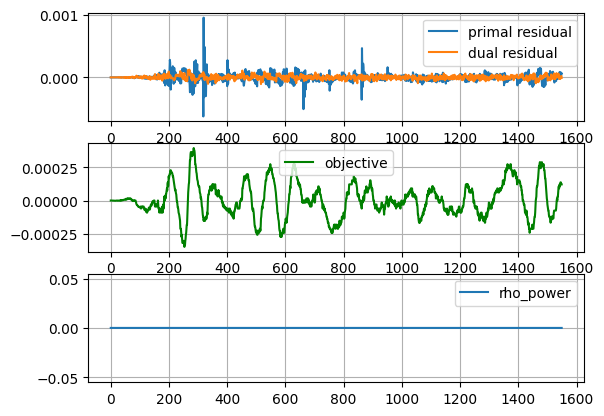

In [9]:

# Make plots of WEIGHTED ADMM - REGULAR ADMM
iter_start = 0
iter_end = 1550


plt.subplot(3,1,1)
plt.plot(np.array(cone_history_admm.power[iter_start:iter_end]) - np.array(cone_history_admm_2.power[iter_start:iter_end]), label='primal residual')
plt.plot(np.array(cone_history_admm.dual_power[iter_start:iter_end]) - np.array(cone_history_admm_2.dual_power[iter_start:iter_end]), label='dual residual')
plt.grid()
plt.legend()
plt.xlabel('Iterations')
plt.subplot(3,1,2)
plt.plot(np.array(cone_history_admm.objective[iter_start:iter_end]) - np.array(cone_history_admm_2.objective[iter_start:iter_end]), label='objective', color='g')
plt.grid()
plt.legend()
plt.xlabel('Iterations')
plt.subplot(3,1,3)
plt.grid()
plt.plot(np.array(cone_history_admm.rho_power[iter_start:iter_end]) - np.array(cone_history_admm_2.rho_power[iter_start:iter_end]), label='rho_power')
plt.legend()





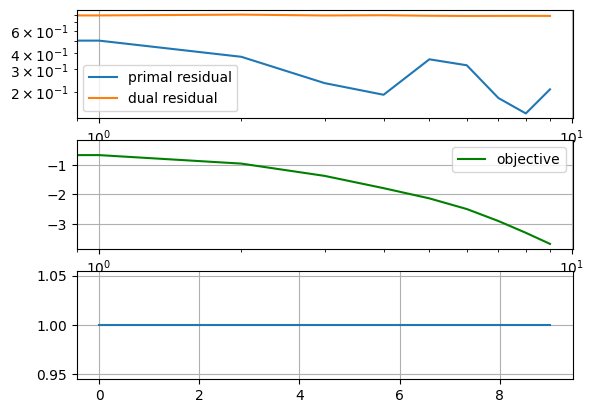

In [11]:
plt.subplot(3,1,1)
plt.loglog(cone_history_admm.power, label='primal residual')
plt.loglog(cone_history_admm.dual_power, label='dual residual')
plt.grid()
plt.legend()
plt.xlabel('Iterations')
plt.subplot(3,1,2)
plt.semilogx(cone_history_admm.objective, label='objective', color='g')
plt.grid()
plt.legend()
plt.xlabel('Iterations')
plt.subplot(3,1,3)
plt.grid()
plt.plot(cone_history_admm.rho_power, label='\rho')





25.0


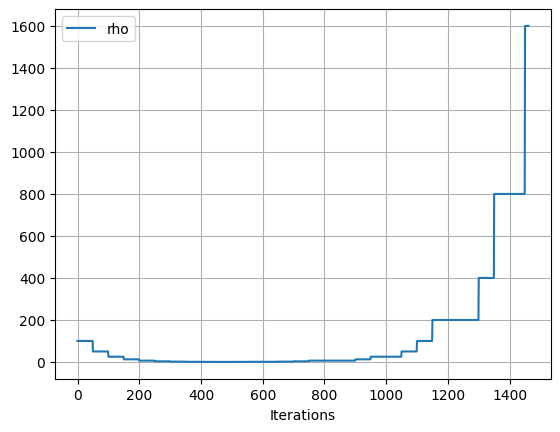

In [11]:
plt.grid()
plt.plot(cone_history_admm.rho_power, label='rho')
plt.legend()
plt.xlabel('Iterations')
print(cone_history_admm.rho_power[1000])

In [22]:
benchmark = MaxFlowBenchmarkSet(num_problems=1, n=100, base_seed=42)
for i, prob in enumerate(benchmark):
    if i == 0:
        problem = prob
        cone_params, _, _ = get_standard_conic_problem(problem, solver=cp.CLARABEL)
problem.solve(solver=cp.CLARABEL)
ref_obj = problem.value

cone_bridge = ConeBridge(cone_params, ruiz_iters=5)
conic_ruiz_sigma = cone_bridge.sigma
machine = "cpu"
dtype = torch.float32
admm_devices = [d.torchify(machine=machine, dtype=dtype) for d in cone_bridge.devices]
admm = WeightedADMMSolver(
    machine=machine,
    dtype=dtype,
    atol=1e-6,
    rtol=1e-6,
    alpha=1.6,
    tau=2,
    adaptive_rho=True,
    num_iterations=1000,
)
solution_admm, history_admm = admm.solve(cone_bridge.net, admm_devices, cone_bridge.time_horizon)


Did not converge. Ran for 1000 iterations.


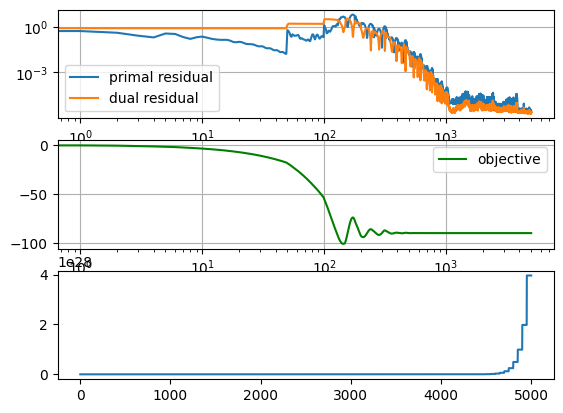

In [20]:
plt.subplot(3,1,1)
plt.loglog(history_admm.power, label='primal residual')
plt.loglog(history_admm.dual_power, label='dual residual')
plt.grid()
plt.legend()
plt.xlabel('Iterations')
plt.subplot(3,1,2)
plt.semilogx(history_admm.objective, label='objective', color='g')
plt.grid()
plt.legend()
plt.xlabel('Iterations')
plt.subplot(3,1,3)
plt.plot(history_admm.rho_power)



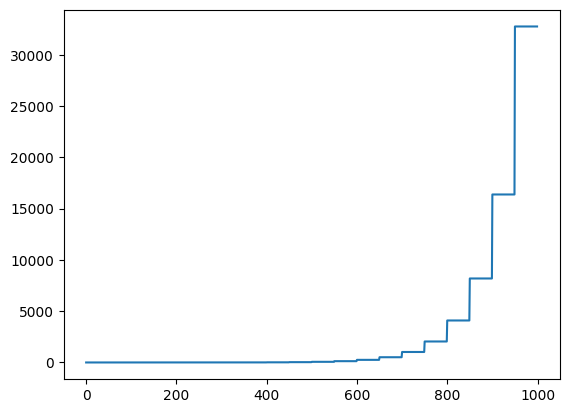

In [23]:
plt.plot(history_admm.rho_power)
